In [1]:
%matplotlib inline

import cv2
import time
import json
import rasterio
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import osr
from PIL import Image
from tabulate import tabulate as tab

plt.rcParams['image.cmap'] = 'gray'

def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

### I. Read Master and Slave Images

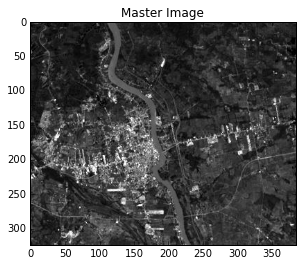

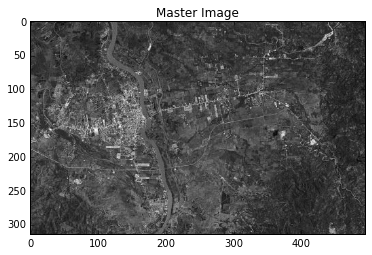

In [2]:
MASTER_IMAGE_PATH = 'images/Butuan.Master.jpg'
SLAVE_IMAGE_PATH = 'images/Butuan.Slave.02.jpg'

master_image = cv2.imread(MASTER_IMAGE_PATH, cv2.CV_LOAD_IMAGE_GRAYSCALE)
slave_image = cv2.imread(SLAVE_IMAGE_PATH, cv2.CV_LOAD_IMAGE_GRAYSCALE)

show_image(master_image, "Master Image")
show_image(slave_image, "Master Image")

### II. Keypoint Matching

In [3]:
surf = cv2.SURF(900)   # keypoint detector and descriptor
bf = cv2.BFMatcher()   # keypoint matcher

#### Extract keypoints from both master and slave images 

In [4]:
k1, d1 = surf.detectAndCompute(master_image, None)
k2, d2 = surf.detectAndCompute(slave_image, None)

#### Compute matches
Compute matches between the two set of keypoints, then filter out the matches based on a distance threshold

In [5]:
matches = bf.match(d1, d2)

dist = [m.distance for m in matches]
distance_threshold =(sum(dist) / len(dist)) * 0.63

sel_matches = [m for m in matches if m.distance < distance_threshold]

print 'Matches:', len(matches)
print 'Distance: min: %.3f' % min(dist)
print 'Distance: mean: %.3f' % (sum(dist) / len(dist))
print 'Distance: max: %.3f' % max(dist)
print 'Selected matches:', len(sel_matches)

Matches: 418
Distance: min: 0.216
Distance: mean: 0.460
Distance: max: 0.655
Selected matches: 7


#### Extract image coordinates of matches

In [6]:
master_keypoints = np.array([ k1[m.queryIdx].pt for m in sel_matches], dtype=np.float32)
slave_keypoints = np.array([ k2[m.trainIdx].pt for m in sel_matches], dtype=np.float32)

print master_keypoints

[[ 154.45825195  156.14305115]
 [ 352.18652344  116.70993805]
 [  22.60409164  133.97520447]
 [ 123.4943924   238.36108398]
 [ 163.2401123   301.69888306]
 [ 162.29234314  120.70710754]
 [ 194.0944519   144.21406555]]


### Visualize Matches

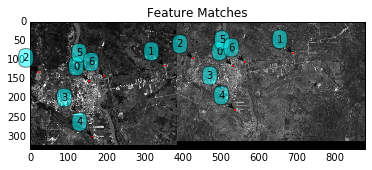

In [7]:
h1, w1 = master_image.shape[:2]
h2, w2 = slave_image.shape[:2]

output_image = sp.zeros((max(h1, h2) + 10, w1 + w2, 3), sp.uint8)
output_image[:h1, :w1, 0] = master_image
output_image[:h2, w1:, 0] = slave_image
output_image[:, :, 1] = output_image[:, :, 0]
output_image[:, :, 2] = output_image[:, :, 0]

cols1 = master_image.shape[1]
cols2 = slave_image.shape[1]

for mat in sel_matches:
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    (x1, y1) = k1[img1_idx].pt
    (x2, y2) = k2[img2_idx].pt

    cv2.circle(output_image, (int(x1),int(y1)), 1, (255, 0, 0), 2)   
    cv2.circle(output_image, (int(x2) + cols1,int(y2)), 1, (255, 0, 0), 2)

labels = ['{0}'.format(i) for i in xrange(len(master_keypoints))]
plt.subplots_adjust(bottom = 0)
for label, x, y in zip(labels, master_keypoints[:, 0], master_keypoints[:, 1]):
    plt.annotate( 
        label, xy=(x, y), xytext = (-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle = 'round4,pad=0.5', fc='cyan', alpha=0.5),
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.subplots_adjust(bottom=0)
for label, x, y in zip(labels, (slave_keypoints[:, 0] + cols1), slave_keypoints[:, 1]):
    plt.annotate(
        label, xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round4,pad=0.5', fc='cyan', alpha=0.5),
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'))   
    
show_image(output_image, "Feature Matches")

## III. Georeference Slave Image
Use feature matches to compute global coordinates within the slave image

In [26]:
with rasterio.drivers():
    with rasterio.open(MASTER_IMAGE_PATH) as master_src:
        c1, a1, b1, f1, d1, e1 = master_src.get_transform()
        print json.dumps(master_src.profile, indent=2)

{
  "count": 3, 
  "crs": {}, 
  "dtype": "uint8", 
  "affine": [
    1.1016563707e-07, 
    0.0, 
    125.52501375617767, 
    0.0, 
    -6.991878683e-08, 
    9.002214933701698, 
    0.0, 
    0.0, 
    1.0
  ], 
  "driver": "JPEG", 
  "transform": [
    125.52501375617767, 
    1.1016563707e-07, 
    0.0, 
    9.002214933701698, 
    0.0, 
    -6.991878683e-08
  ], 
  "height": 324, 
  "width": 385, 
  "blockxsize": 385, 
  "tiled": false, 
  "blockysize": 1, 
  "nodata": null
}


In [40]:
x_value = master_keypoints[:, 0]
y_value = master_keypoints[:, 1]

xp = a1 * x_value + b1 * y_value + a1 * 0.5 + b1 * 0.5 + c1
yp = d1 * x_value + e1 * y_value + d1 * 0.5 + e1 * 0.5 + f1

master_gcoords = np.array([xp, yp], dtype=np.float32).T

print master_gcoords

[[ 125.52503204    9.0022049 ]
 [ 125.52505493    9.0022068 ]
 [ 125.52501678    9.00220585]
 [ 125.52503204    9.00219822]
 [ 125.52503204    9.0021944 ]
 [ 125.52503204    9.0022068 ]
 [ 125.52503967    9.0022049 ]]


In [28]:
# with rasterio.drivers():
#     with rasterio.open(SLAVE_IMAGE_PATH) as slave_src:
#         print json.dumps(slave_src.profile, indent=2)

In [43]:
print slave_keypoints

[[ 146.19915771  116.02167511]
 [ 304.72198486   84.87580109]
 [  42.23839188   97.51493835]
 [ 120.81288147  180.48278809]
 [ 151.1084137   232.2142334 ]
 [ 152.79367065   86.9480896 ]
 [ 177.540802    106.82711029]]


In [51]:
gcps = np.hstack([master_gcoords, slave_keypoints, ])
print gcps

[[ 125.52503204    9.0022049   146.19915771  116.02167511]
 [ 125.52505493    9.0022068   304.72198486   84.87580109]
 [ 125.52501678    9.00220585   42.23839188   97.51493835]
 [ 125.52503204    9.00219822  120.81288147  180.48278809]
 [ 125.52503204    9.0021944   151.1084137   232.2142334 ]
 [ 125.52503204    9.0022068   152.79367065   86.9480896 ]
 [ 125.52503967    9.0022049   177.540802    106.82711029]]


In [60]:
master_gcoords = np.float32([[50,50],[200,50],[50,200]])
slave_keypoints = np.float32([[10,100],[200,50],[100,250]])
print cv2.getAffineTransform(master_gcoords, slave_keypoints)

[[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]
